In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
from os import listdir
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
Adam = tf.keras.optimizers.Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/My Drive/nail_dataset_new'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for nail_folder in root_dir :
        nail_disease_folder_list = listdir(f"{directory_root}/{nail_folder}")
        
        for disease_folder in nail_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                nail_disease_folder_list.remove(disease_folder)

        for nail_disease_folder in nail_disease_folder_list:
            print(f"[INFO] Processing {nail_disease_folder} ...")
            nail_disease_image_list = listdir(f"{directory_root}/{nail_folder}/{nail_disease_folder}/")
                
            for single_nail_disease_image in nail_disease_image_list :
                if single_nail_disease_image == ".DS_Store" :
                    nail_disease_image_list.remove(single_nail_disease_image)
            for image in nail_disease_image_list[:200]:
                image_directory = f"{directory_root}/{nail_folder}/{nail_disease_folder}/{image}"
                if image_directory.endswith(".png") == True or image_directory.endswith(".PNG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(nail_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
Error : [Errno 2] No such file or directory: '/content/drive/My Drive/nail_dataset_new'


In [ ]:
image_size = len(image_list)
print(image_size)

0


In [ ]:
import pickle
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

ValueError: ignored

In [ ]:
print(label_binarizer.classes_)

["Darier's disease" "Muehrck-e's lines" 'aloperia areata' "beau's lines"
 'bluish nail' 'clubbing' 'eczema'
 "half and half nailes (Lindsay's nails)" 'koilonychia' 'leukonychia'
 'onycholycis' 'pale nail' 'red lunula' 'splinter hemmorrage'
 "terry's nail" 'whitenail' 'yellow nails']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.1, random_state = 42)

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(n_classes))
model.add(Activation("softmax"))


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_42 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_36 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 85, 85, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 85, 85, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 85, 85, 64)       

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/100
18/18 [==============================] - 9s 455ms/step - loss: 0.8449 - accuracy: 0.1346 - val_loss: 0.7461 - val_accuracy: 0.0152
Epoch 2/100
18/18 [==============================] - 7s 410ms/step - loss: 0.6492 - accuracy: 0.1670 - val_loss: 0.6747 - val_accuracy: 0.0303
Epoch 3/100
18/18 [==============================] - 7s 428ms/step - loss: 0.5216 - accuracy: 0.1849 - val_loss: 0.4957 - val_accuracy: 0.0152
Epoch 4/100
18/18 [==============================] - 7s 406ms/step - loss: 0.3720 - accuracy: 0.2029 - val_loss: 1.0058 - val_accuracy: 0.0606
Epoch 5/100
18/18 [==============================] - 7s 409ms/step - loss: 0.2839 - accuracy: 0.1885 - val_loss: 1.9429 - val_accuracy: 0.0455
Epoch 6/100
18/18 [==============================] - 7s 410ms/step - loss: 0.2278 - accuracy: 0.2226 - val_loss: 2.8832 - val_accuracy: 0.0455
Epoch 7/100
18/18 [==============================] - 7s 405ms/step - loss: 0.2016 - accuracy: 0.2873 - val_loss: 2.9607 - val_accuracy: 0.0606

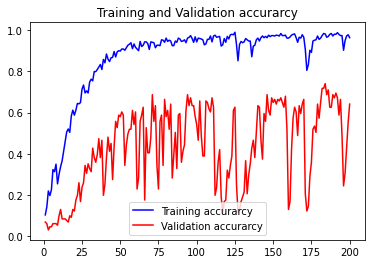

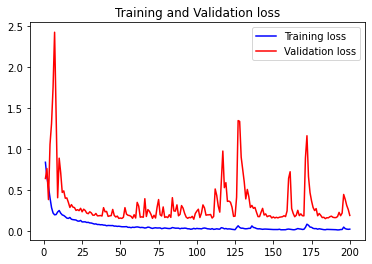

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
5/5 [==============================] - 0s 30ms/step - loss: 0.1896 - accuracy: 0.6412
Test Accuracy: 64.12213444709778


In [ ]:
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

In [ ]:
print("[INFO] Saving model")
model.save("nailmodel.h5")

In [ ]:
image_dir='/content/drive/My Drive/nail_dataset_new/nail_diseases/whitenail/14.PNG'
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error : {e}")
        return None
image_dir='/content/drive/My Drive/nail_dataset_new/nail_diseases/whitenail/14.PNG'
img3 = cv2.imread('/content/drive/My Drive/nail_dataset_new/nail_diseases/whitenail/14.PNG')
plt.imshow(img3)
plt.show()

In [ ]:
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)


result= model.predict(npp_image)
#print(result)

itemindex = np.where(result==np.max(result))
#print(itemindex[1][0])


reverse_mapping = ["Darier's disease","Muehrck-e's lines",'aloperia areata',"beau's lines",
 'bluish nail', 'clubbing' ,'eczema',
 "half and half nailes (Lindsay's nails)" ,'koilonychia', 'leukonychia',
 'onycholycis', 'pale nail' ,'red lunula', 'splinter hemmorrage',
 "terry's nail" ,'white nail', 'yellow nails']
prediction_name = reverse_mapping[itemindex[1][0]]
print(prediction_name)


#printing result
itemindex = np.where(result==np.max(result))
print("Probability of " + prediction_name + "  is: " +str(np.max(result)))
print("Final Diagonasis result : " +prediction_name)
